# Análisis de diversidad de rango para los conteos de entradas en las estaciones del sistema Ecobici

Este segmento está enfocado a realizar un análisis en el uso de las estaciones del sistema de bike sharing de Ecobici utilizando un método conocido como diversidad de rango.

¿Qué es diversidad de rango?

Diversidad de rango es una propiedad que emerge de algunos sistemas complejos de manera que al jerarquizar la actividad de los elementos que conforman un sistema algunos se mantendrán menor variabilidad con respecto a los demás. Diversidad de rango agrupa en una terna a los elementos que forman parte de la distribución: Head es la parte de la distribución donde se agrupan aquellas estaciones que tuvieron la menor variabilidad con respecto a los demás elementos en la distribución, Body es la fracción de la distribución donde se concentran aquellos elementos que constantemente están cambiando de rango a lo largo del tiempo y Tail es la fracción de la distribución de los elementos con menor actividad en el tiempo, el comportamiento de este último puede ser distinto dependiendo del sistema que se analice, en vista de que Ecobici puede interpretarse como un sistema cuasi cerrado los elementos que forman parte de esta fracción en la distribución presentan baja variabilidad.

Diversidad de rango ya ha sido utilizado con anterioridad como una medida para determinar la probabilidad que tiene una palabra para ser sustituida en un vocabulario y en la literatura utilizando la biblioteca virtual de libros recopilados de google. La hipótesis que se plantea aquí es que los elementos del sistema que muestren la menor variabilidad en el sistema en comparación con los demás contienen una señal de uso más estable y con ella más predecible, de esta manera se pretende utilizar este método para comparar el pronóstico realizado en comparación con los elementos que ocupan la parte central en la diversidad y determinar si el error de predicción varía con respecto a la posición que el elemento ocupe en diversidad de rango.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from sklearn import preprocessing

Las siguientes funciones serán utilizadas de manera repetida para obtener la diversidad de rango de fragmentos de tiempo en los registros. También se realiza una gráfico sobre el número de intersecciones que tuvieron las estaciones en los diferentes rangos: 

In [2]:
def get_dr(phase):
    data = dict([(r[0], list(phase.columns[np.argsort(list(r)[1: ])[::-1]])) \
        for r in list(phase.to_records())])
    
    dr = pd.DataFrame.from_dict(data, orient='index', dtype=None)
    dr = dr.sort_index()

    return dr

In [3]:
def plot_dr(dr,title):
    
    dct = {func.__name__:dr.apply(func) for func in (pd.Series.nunique, pd.Series.count)}    
    fig, ax = plt.subplots(1, figsize=(16, 8))
    plt.title(title)

    xticks = (pd.concat(dct, axis=1)['nunique']/len(dr.index)).index
    keptticks = xticks[::int(len(xticks)/20)]
    xticks = ['' for y in xticks]
    xticks[::int(len(xticks)/20)] = keptticks

    #(pd.concat(dct, axis=1)['nunique']/len(dr.index)).plot(kind='bar')
    ax = (pd.concat(dct, axis=1)['nunique']/len(dr.index)).plot(xticks=(pd.concat(dct, axis=1)['nunique']/len(dr.index)).index, rot=90, kind='bar')
    ax.set_xticklabels(xticks)

In [4]:
def plot_rank_rep(dr):
    i = 0
    array = np.array([])
    for i in range(dr.values.shape[1]):
        uniques = np.unique(dr.values[:,i])
        array = np.concatenate((array,uniques))

    y = np.bincount(array.astype(int))
    ii = np.nonzero(y)[0]   

    station_rank = pd.DataFrame(np.vstack((ii,y[ii])).T, columns=['estacion','repeticiones']).sort_values('repeticiones')
    station_rank[:140].plot(x='estacion',y='repeticiones',kind='bar',color='b',figsize=(19, 8),title='Station against rank ')

In [5]:
def load_daytrips():
    path = 'ecobici.csv'
    trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)
    
    trips = trips.loc[trips['action'] != 'C  ']

    # Find the start date
    ind = pd.DatetimeIndex(trips.date_arrived)
    trips['date'] = ind.date.astype('datetime64')
    trips['hour'] = ind.hour

    # Count trips by date
    by_date = trips.pivot_table('bike',aggfunc='count',
                            index='date',
                            columns='station_arrived', )

    # add a flag indicating weekend
    by_date['weekend'] = (by_date.index.dayofweek >= 5)
    
    by_date_weekday = by_date[by_date['weekend'] == False]

    mavg_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_wd = by_date_weekday.sum(axis=1).rolling(window=20,center=False).std()

    black_list = by_date_weekday.sum(axis=1)[by_date_weekday.sum(axis=1) <= mavg_wd-2*mstd_wd].index

    by_date_weekend = by_date[by_date['weekend'] == True]

    mavg_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).mean()
    mstd_we = by_date_weekend.sum(axis=1).rolling(window=20,center=False).std()

    black_list = black_list.union(by_date_weekend.sum(axis=1)[by_date_weekend.sum(axis=1) <= mavg_we-2*mstd_we].index)
    
    # remove those values on the blacklist
    by_date = by_date.fillna(0)
    by_date = by_date.loc[~by_date.index.isin(black_list)]
    
    return by_date

In [6]:
def frequencyRank(column):
    return column.value_counts()

In [7]:
def normalizeColumns(data):
    
    #returns scaled column values of a pandas dataset
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    
    return pd.DataFrame(x_scaled)

In [8]:
def plot_freqHeatmap(data):
    norm_data = normalizeColumns(data)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    yticks = data.index
    keptticks = yticks[::int(len(yticks)/10)]
    yticks = ['' for y in yticks]
    yticks[::int(len(yticks)/10)] = keptticks
    
    xticks = data.columns
    keptticks = xticks[::int(len(xticks)/10)]
    xticks = ['' for y in xticks]
    xticks[::int(len(xticks)/10)] = keptticks

    ax[0].set_title('Station over rank frequency')
    ax[1].set_title('Normalized Station over rank frequency')

    sns.heatmap(data, ax=ax[0], yticklabels=yticks, xticklabels=xticks)
    sns.heatmap(norm_data, ax=ax[1], yticklabels=yticks, xticklabels=xticks)
    
    # This sets the yticks "upright" with 0, as opposed to sideways with 90.
    plt.yticks(rotation=0) 
    
    plt.show()

Primero que nada deberemos cargar el archivo para reconocer las fases a las que pertenecen las estaciones, así será posible realizar un análisis más específico sobre el periodo de la fase que se quiere visualizar

In [9]:
station_phase_path = 'ecobiciFases.csv'
station_phase = pd.read_csv(station_phase_path,header=None)
station_phase.columns = ['station','phase']

### Fase 1

Como se ha mencionado anteriormente, es de interés conocer si las estaciones que regularmente conservan una jerarquía en el uso dentro del sistema y poder determinar si esta estructura puede ayudar a establecer un grado de predictibilidad asociado.

Obteniendo los elementos a considerar en el periodo que comprende la fase 1 analizamos solamente el periodo comprendido entre el 20 de febrero del 2010 hasta finales de octubre del 2012 con las estaciones que existían en ese periodo, es decir, las estaciones con ID de la 1 a la 90:

In [10]:
by_date = load_daytrips()

by_date.drop([col for col in list(by_date.columns.values) if col not in station_phase[station_phase['phase'] <= 1]['station'].values or col >= 260], 
        axis=1, inplace=True)

phase_1 = by_date['2010-02-20':'2012-10-29']


C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


Una vez obtenido el periodo que nos interesa, se procede a realizar lo siguiente:
Para cada día se ordenas las estaciones en función de sus conteos, de mayor a menor, donde la estación que obtuvo el uso más alto se encuentra en la primer posición, la seguido de la segunda estación con más uso ordenando por frecuencia de actividad todas las estaciones. 

Una vez obtenido este orden se procede a contar el número de estaciones únicas que ocuparon el lugar 1...n en el periodo de tiempo comprendido, después la cifra es  dividida entre el número de días que se utilizó para construir la diversidad de rango, obteniendo lo siguiente:

In [11]:
dr = get_dr(phase_1)

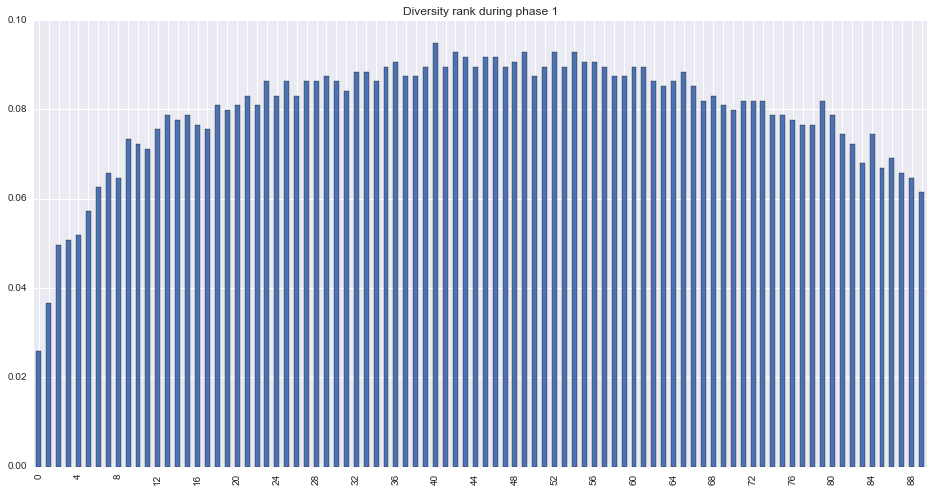

In [12]:
plot_dr(dr,'Diversity rank during phase 1')

Esta visualización nos habla un poco del comportamiento global del sistema a lo largo de un periodo de tiempo. Se puede apreciar por la figura obtenida que la diversidad de estaciones que conforman los extremos de la distribución (head y tail) son menores, lo que se asume es que las estaciones que aparecen en la cabeza tienen una baja probabilidad de saltar a lugares más altos en los rangos a lo largo del tiempo pero esta probabilidad aumenta drásticamente conforme se va avanzando en el orden de los rangos.

Si tenemos en consideración la manera en que fue elaborado el gráfico anterior podemos intuir que una estación puede estar presente en más de un rango mas no es posible conocer su frecuencia en el gráfico anterior. A continuación el siguiente gráfico muestra el número de veces que estuvo presente estación a lo largo de los rangos:

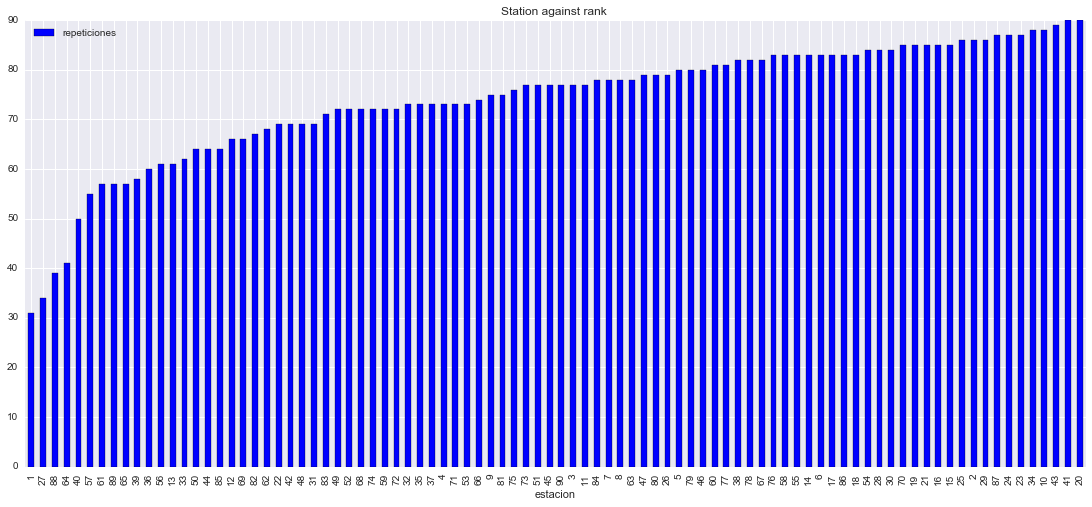

In [13]:
plot_rank_rep(dr)

A modo de ilustración a continuación se muestran dos heatmaps: En la figura izquierda las filas representan las 90 estaciones comprendidas durante la fase 1, las columnas se tienen los rango y las celdas contienen la frecuencia que tuvo la $estación_i$ en el $rango_j$ en el periodo de tiempo. La figura en la parte derecha indica lo mismo con la única diferencia de que los valores han sido normalizados a lo largo de las columnas. 

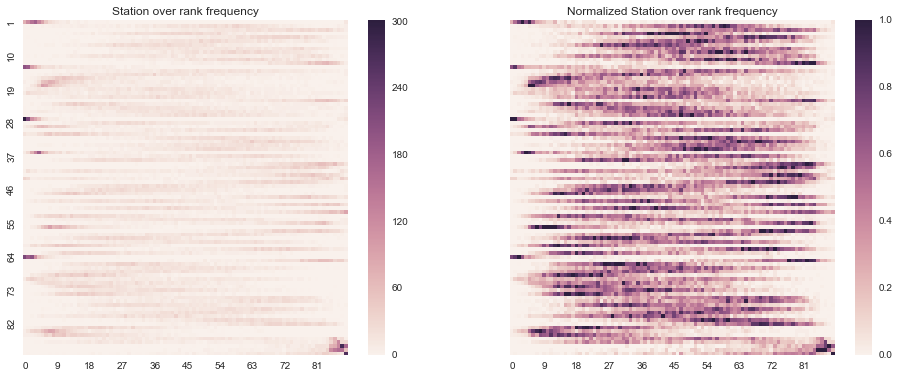

In [14]:
a1 = dr.apply(frequencyRank, axis=0).fillna(0)
plot_freqHeatmap(a1)

Donde se observa que en los primeros 4 lugares, por ejemplo, aparecen la estación 1, 27, 64 y 88 que son las estaciones con menos presencia obtuvieron en la diversidad de rango y puede ofrecernos información sobre la estabilidad de estas estaciones dentro del sistema.

### Análisis tomando en cuenta días de la semana iguales.

El análisis que se hace en la sección anterior aporta una manera de apreciar la estabilidad del orden de las estaciones en el sistema para toda la semana ¿ocurrirá algo distinto si separamos los días analizados por días iguales?

Al conjunto de datos del que ya disponemos agregamos una etiqueta para marcar en qué día de la semana cae:

In [15]:
# add a flag indicating the day of the week
dr['day_week'] = dr.index.dayofweek

Obtenemos subconjuntos de los días según el día de la semana en el que se encuentre:

In [16]:
monday = dr[dr['day_week'] == 0].iloc[:,:-1]
tuesday = dr[dr['day_week'] == 1].iloc[:,:-1]
wednesday = dr[dr['day_week'] == 2].iloc[:,:-1]
thursday = dr[dr['day_week'] == 3].iloc[:,:-1]
friday = dr[dr['day_week'] == 4].iloc[:,:-1]
satuday = dr[dr['day_week'] == 5].iloc[:,:-1]
sunday = dr[dr['day_week'] == 6].iloc[:,:-1]

Se realiza la gráfica de diversidad de rango y la de frecuencia en repeticiones de las estaciones por rango para cada día de la semana:

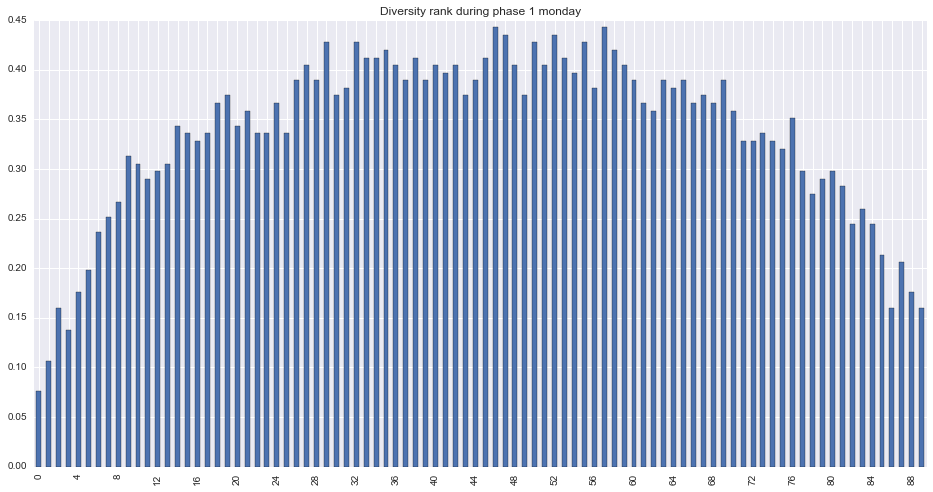

In [17]:
plot_dr(monday,'Diversity rank during phase 1 monday')

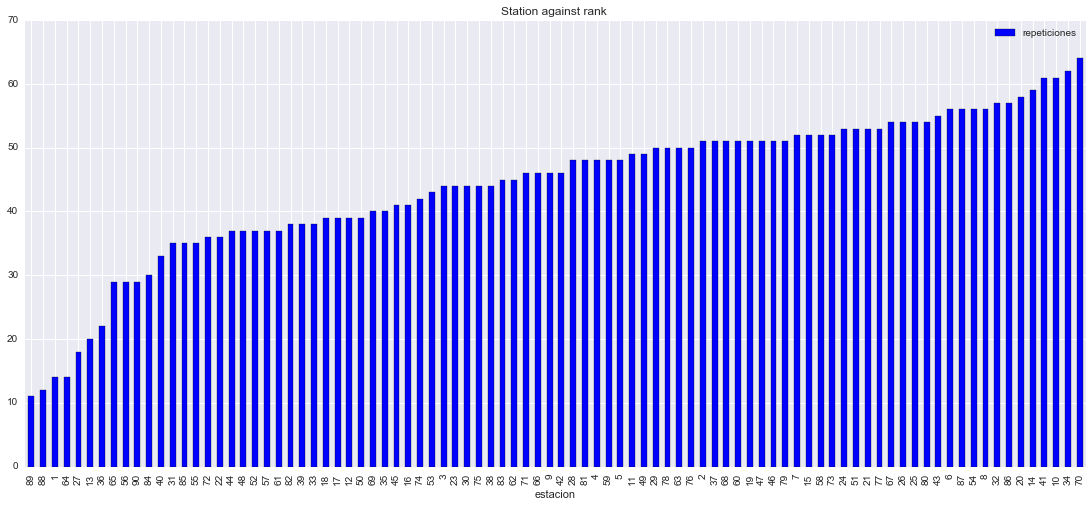

In [18]:
plot_rank_rep(monday)

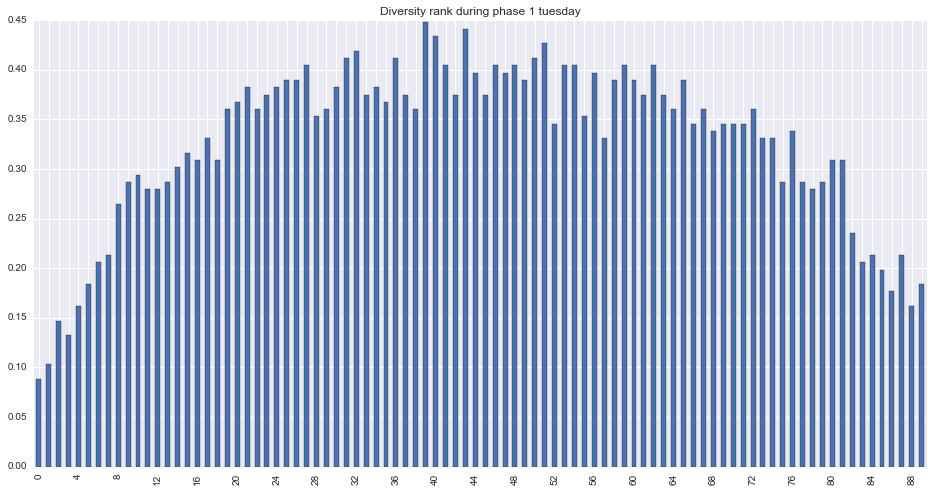

In [19]:
plot_dr(tuesday,'Diversity rank during phase 1 tuesday')

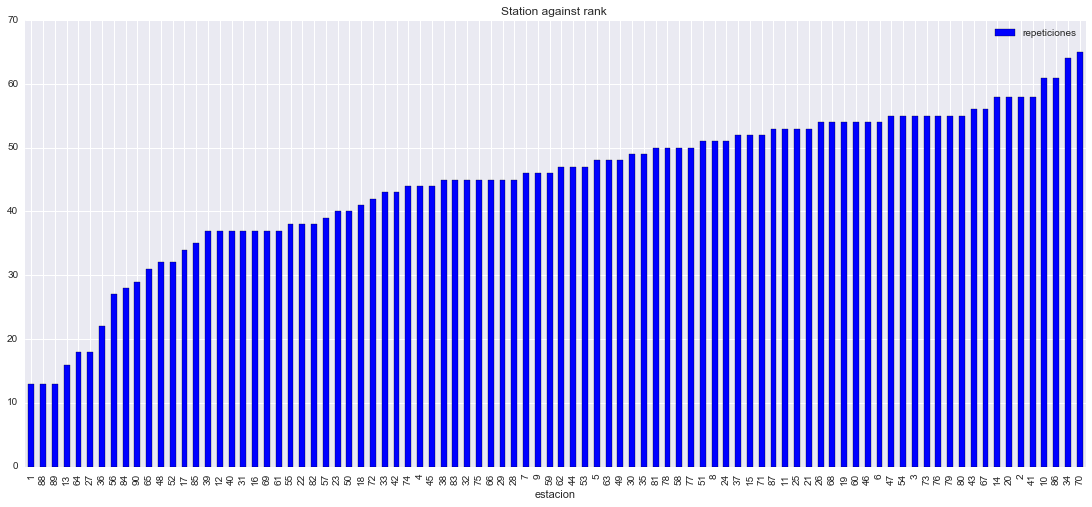

In [20]:
plot_rank_rep(tuesday)

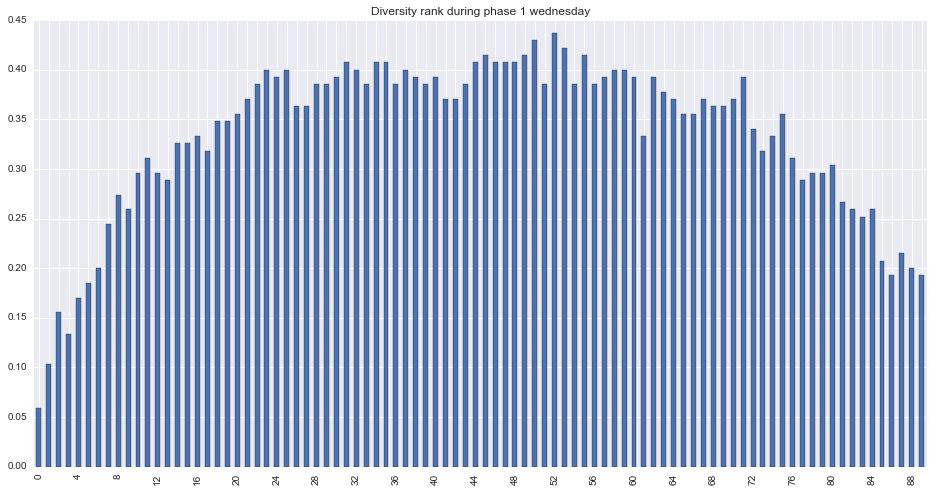

In [21]:
plot_dr(wednesday,'Diversity rank during phase 1 wednesday')

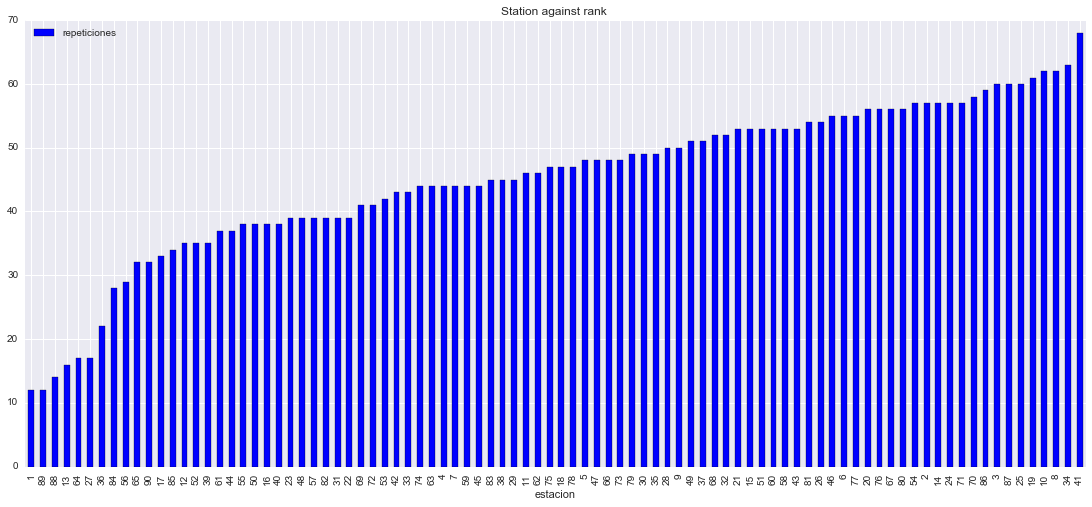

In [22]:
plot_rank_rep(wednesday)

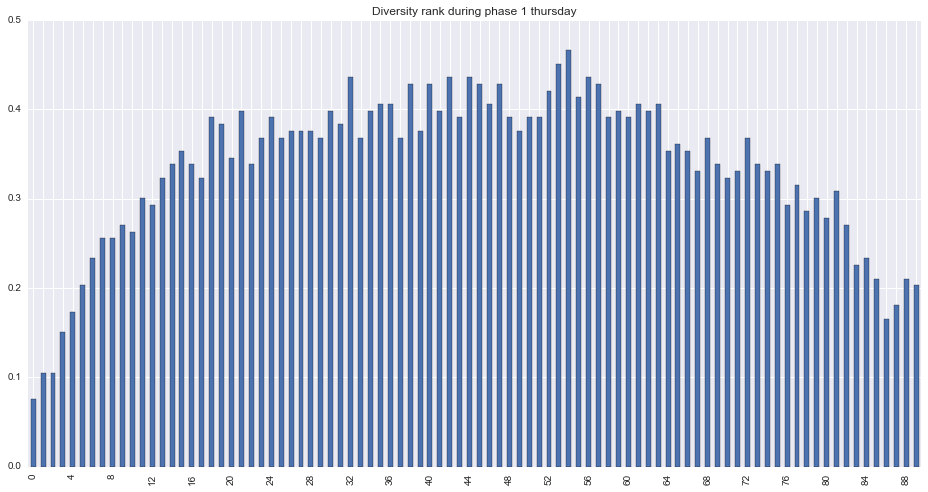

In [23]:
plot_dr(thursday,'Diversity rank during phase 1 thursday')

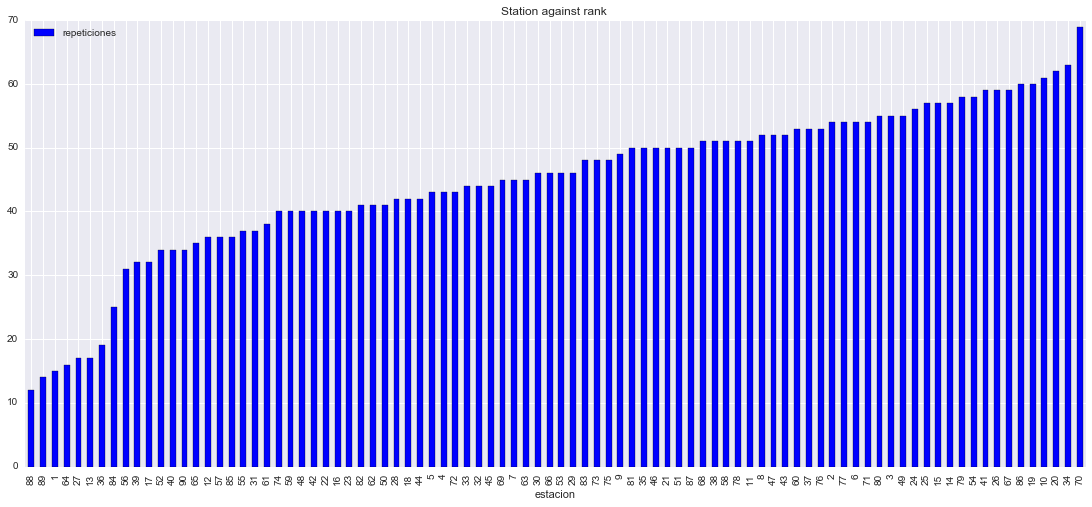

In [24]:
plot_rank_rep(thursday)

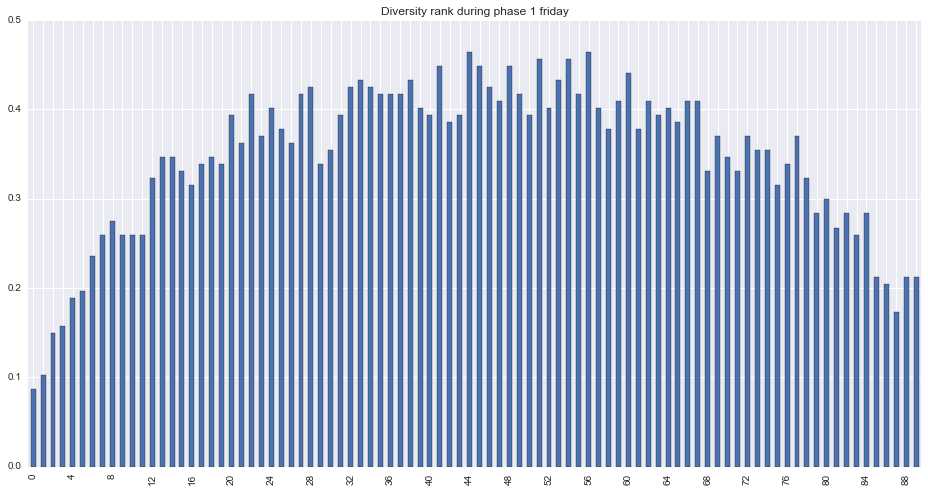

In [25]:
plot_dr(friday,'Diversity rank during phase 1 friday')

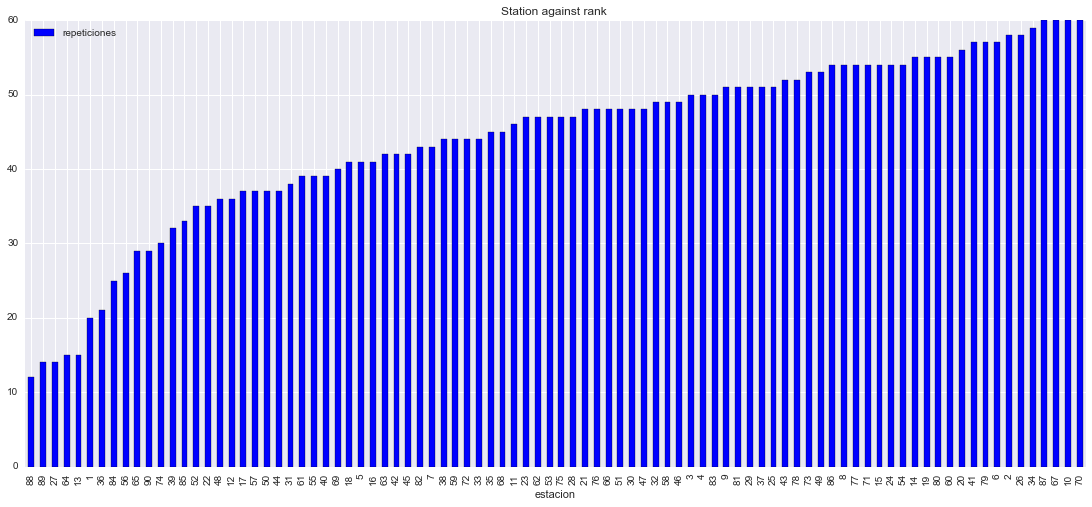

In [26]:
plot_rank_rep(friday)

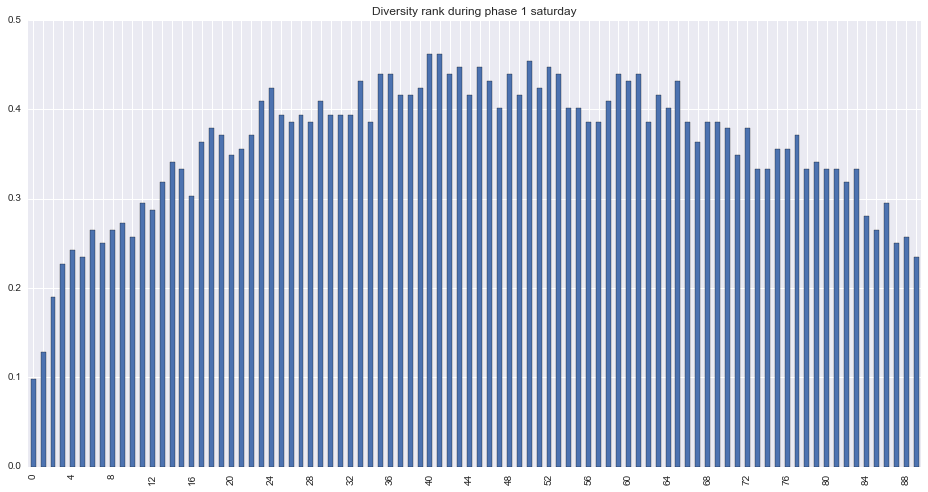

In [27]:
plot_dr(satuday,'Diversity rank during phase 1 saturday')

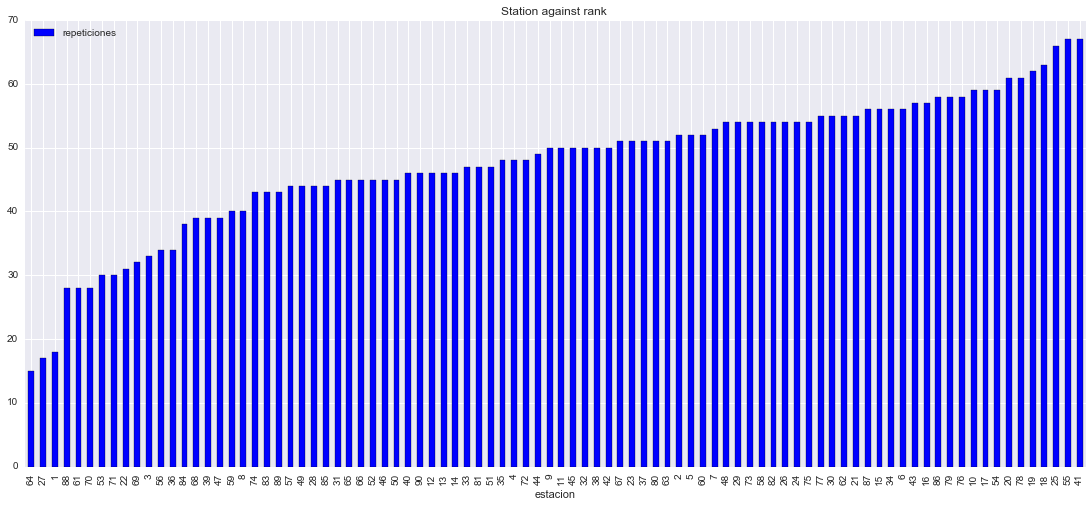

In [28]:
plot_rank_rep(satuday)

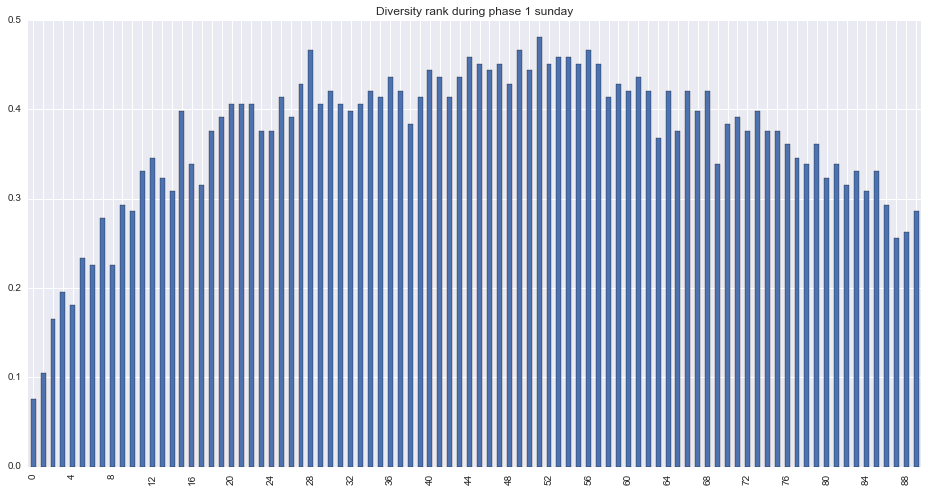

In [29]:
plot_dr(sunday,'Diversity rank during phase 1 sunday')

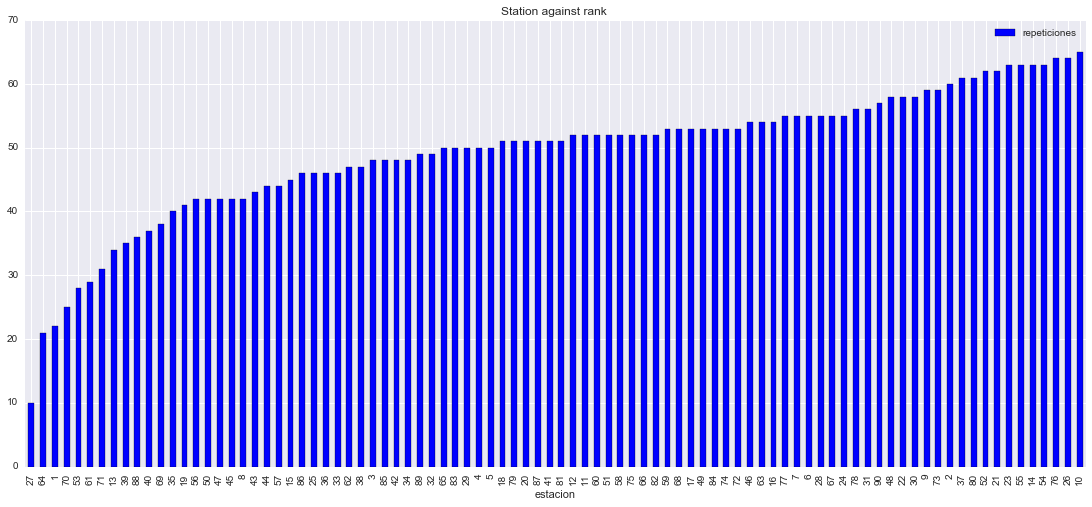

In [30]:
plot_rank_rep(sunday)

Tras las siguientes visualizaciones algunas cosas saltan a la vista:

- El gráfico de diversidad de rango conserva la forma que tiene cuando se realiza la visualización tomando en cuenta todos los días de la semana y tomando los subconjuntos formados por días de la semana.
- En el gráfico donde se muestran las frecuencias de las estaciones con respecto a su presencia en los rangos puede verse que la frecuencia aumenta rápidamente y después disminuye.
- Las estaciones que ocupan menor número de frecuencias en los rangos por lo general son las mismas, sin importar el día de la semana.

# Análisis sobre la fase 3

Una vez realizado el análisis sobre la fase 1 del sistema de Ecobici lo siguiente que hay que hacer es realizar un análisis después del proceso de expansión del sistema, la fase 3 (la fase 2 no fue tomada en cuenta debido a la intersección de tiempos en la implementación de dichas fases, en muy poco tiempo se implementaron una fase seguida de la otra, sin ofrecer un espacio considerable para visualizar una estabilización en su uso, por lo que se optó partir con este análisis desde el principio de la fase 3). Tomamos en cuenta todas las estaciones que pertenecen a la fase 1, 2 y 3 y partimos el análisis desde los últimos días de noviembre del 2012, donde ya la mayoría de las estaciones de la fase 2 y 3 se encuentran en uso.

In [31]:
phase_3 = load_daytrips()
phase_3.drop([col for col in list(phase_3.columns.values) if col not in station_phase[station_phase['phase'] <= 3]['station'].values], 
            axis=1, inplace=True)
phase_3 = phase_3['2012-11-29':]

C:\Users\ghost\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


Como se realizó anteriormente, primero se hace un análisis tomando en cuenta todos los días de la semana y después se hace un segundo análisis sobre subconjuntos conteniendo un día de la semana específico:

In [32]:
dr3 = get_dr(phase_3)

El periodo comprendido abarca alrededor de un año y un mes de uso con un total de 270 estaciones, 180 más que las que comprenden el periodo de la fase 1. En las visualizaciones de los gráficos para mostrar la frecuencia de las estaciones se tomaron las primeras 140 estaciones con el fin de mostrar legibilidad en el gráfico.

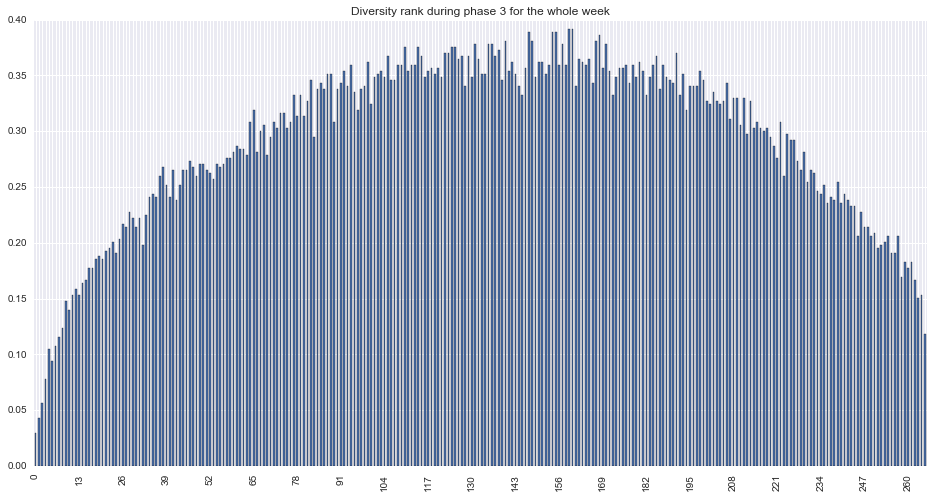

In [33]:
plot_dr(dr3,'Diversity rank during phase 3 for the whole week')

De nueva cuenta se ofrece la visualización con heatmaps sobre las frecuencias de las estaciones a lo largo de sus días:

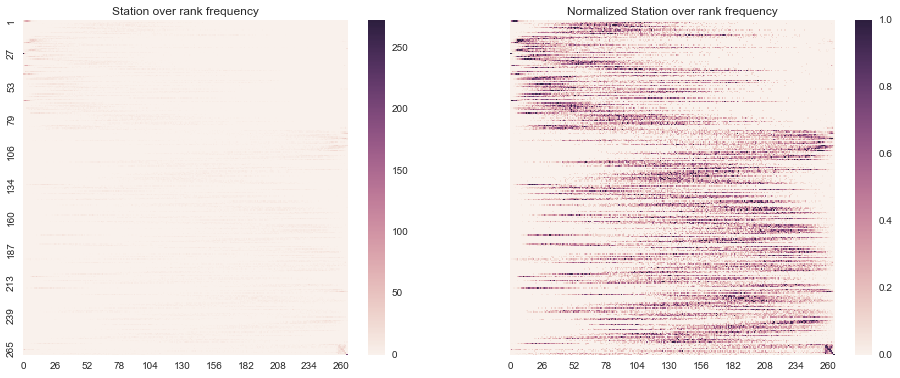

In [34]:
a3 = dr3.apply(frequencyRank, axis=0).fillna(0)
plot_freqHeatmap(a3)

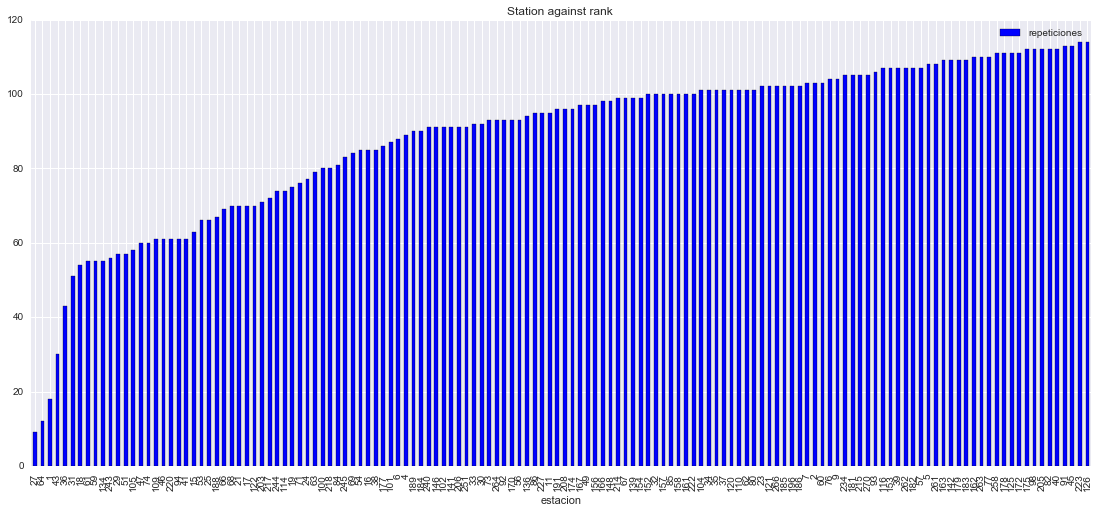

In [35]:
plot_rank_rep(dr3)

Como sucede en el análisis respecto a la fase 1, la diversidad de rango se conserva una forma parabólica, además que existen estaciones que tuvieron muy pocas repeticiones en los diferentes rangos.

Puede verse que algunas estaciones fueron desplazadas  de los primeros lugares, dando lugar a otras. La estación 1 y 27 siguen ocupando un lugar en las estaciones con menores repeticiones.

In [36]:
# add a flag indicating the day of the week
dr3['day_week'] = dr3.index.dayofweek

In [37]:
monday = dr3[dr3['day_week'] == 0].iloc[:,:-1]
tuesday = dr3[dr3['day_week'] == 1].iloc[:,:-1]
wednesday = dr3[dr3['day_week'] == 2].iloc[:,:-1]
thursday = dr3[dr3['day_week'] == 3].iloc[:,:-1]
friday = dr3[dr3['day_week'] == 4].iloc[:,:-1]
satuday = dr3[dr3['day_week'] == 5].iloc[:,:-1]
sunday = dr3[dr3['day_week'] == 6].iloc[:,:-1]

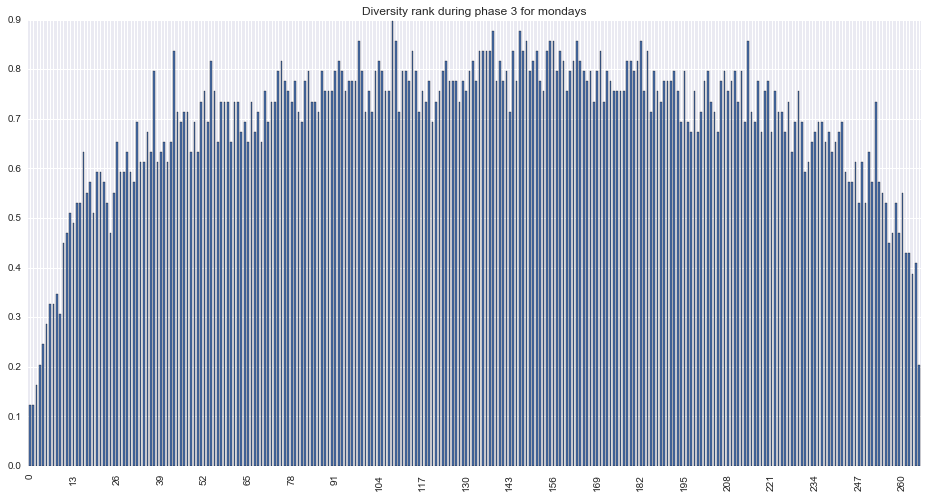

In [38]:
plot_dr(monday,'Diversity rank during phase 3 for mondays')

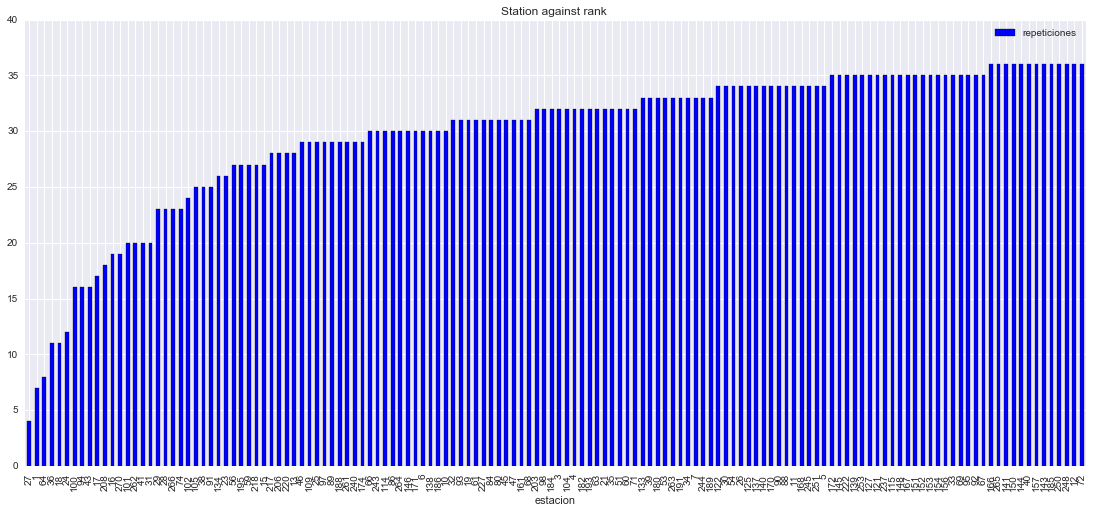

In [39]:
plot_rank_rep(monday)

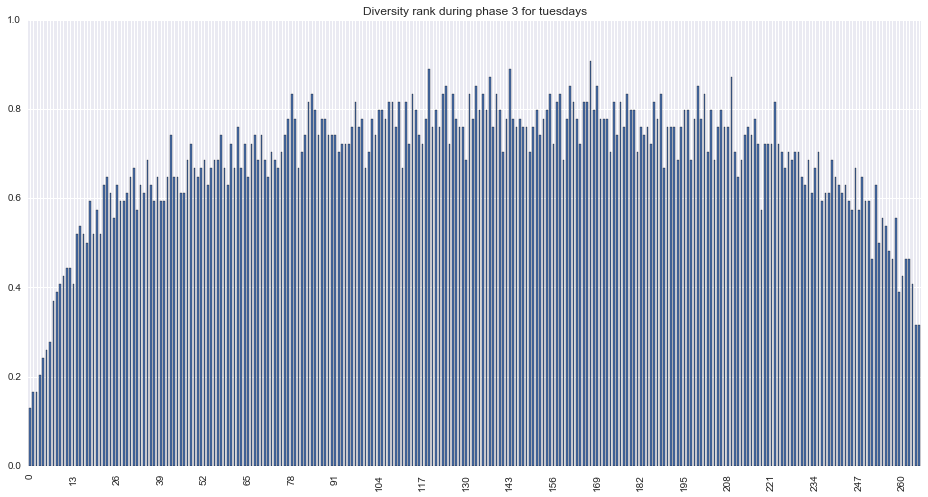

In [40]:
plot_dr(tuesday,'Diversity rank during phase 3 for tuesdays')

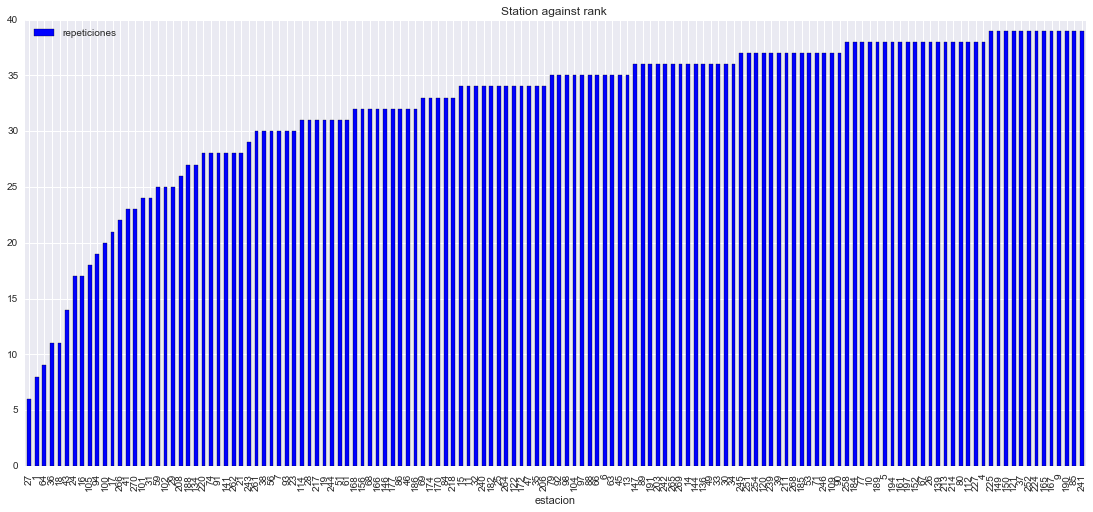

In [41]:
plot_rank_rep(tuesday)

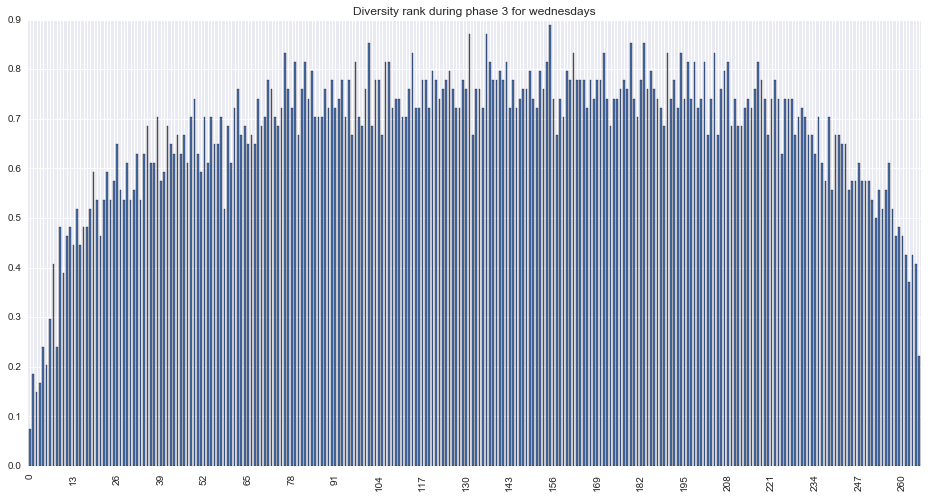

In [42]:
plot_dr(wednesday,'Diversity rank during phase 3 for wednesdays')

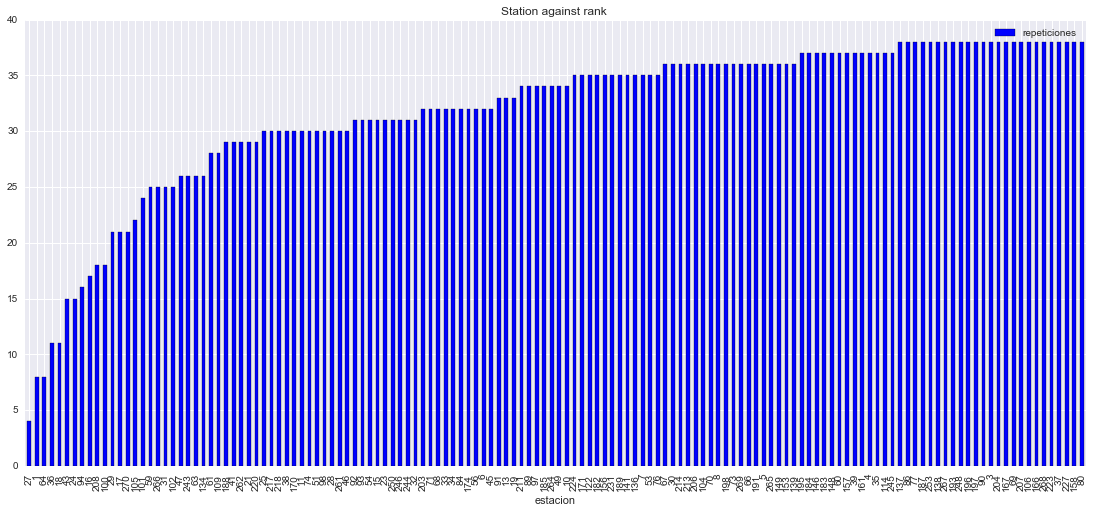

In [43]:
plot_rank_rep(wednesday)

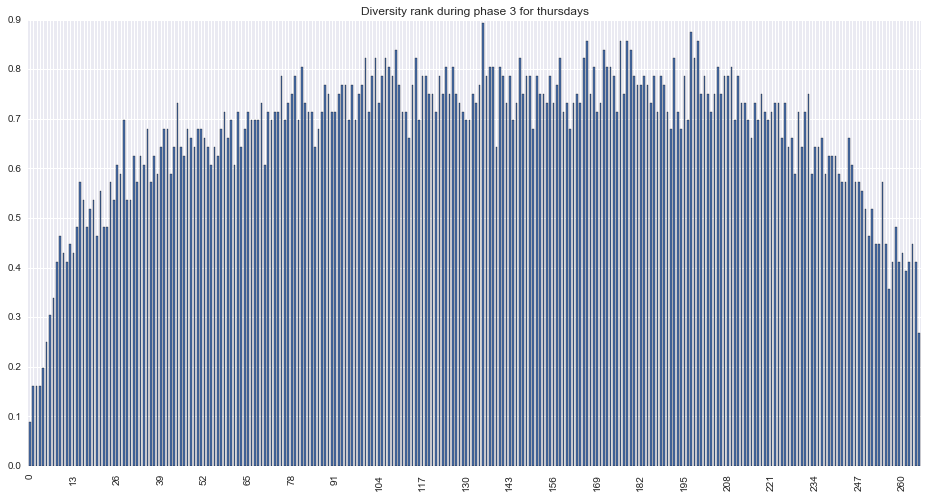

In [44]:
plot_dr(thursday,'Diversity rank during phase 3 for thursdays')

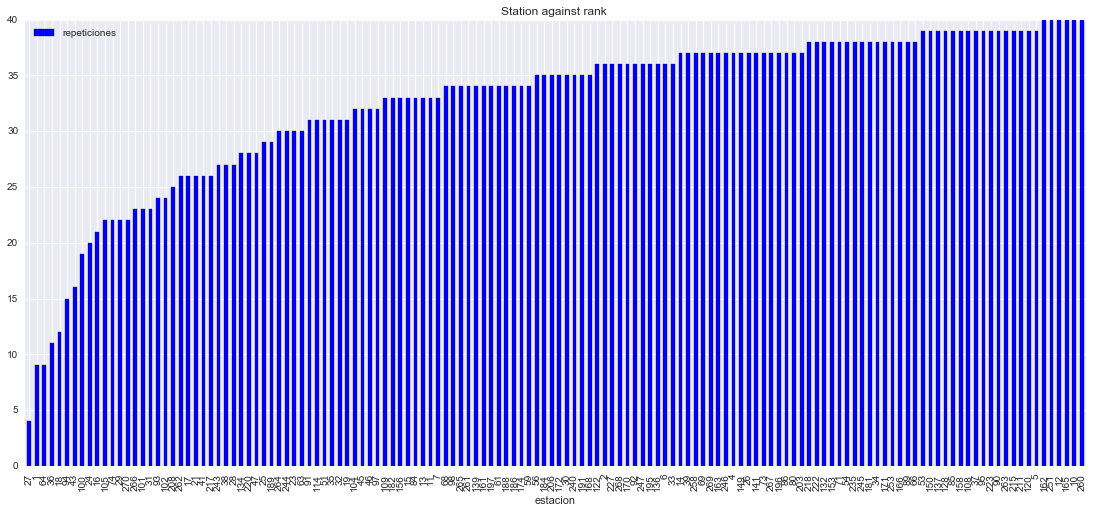

In [45]:
plot_rank_rep(thursday)

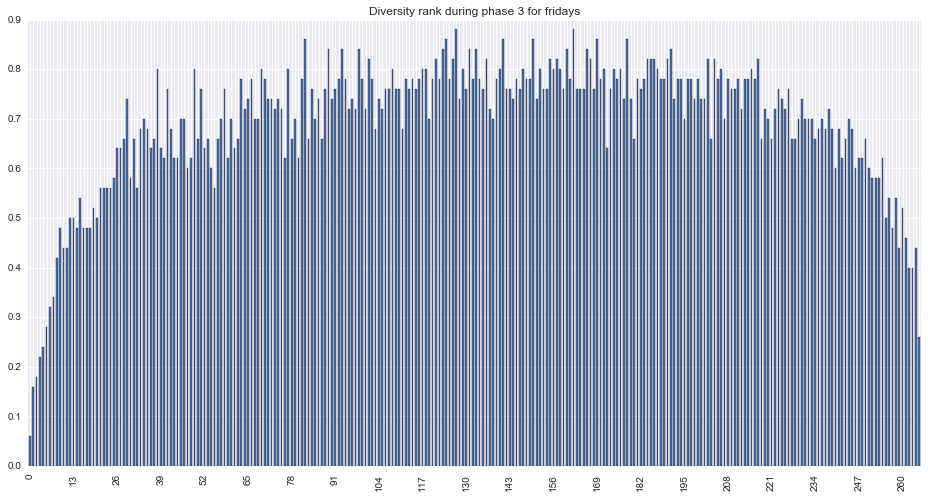

In [46]:
plot_dr(friday,'Diversity rank during phase 3 for fridays')

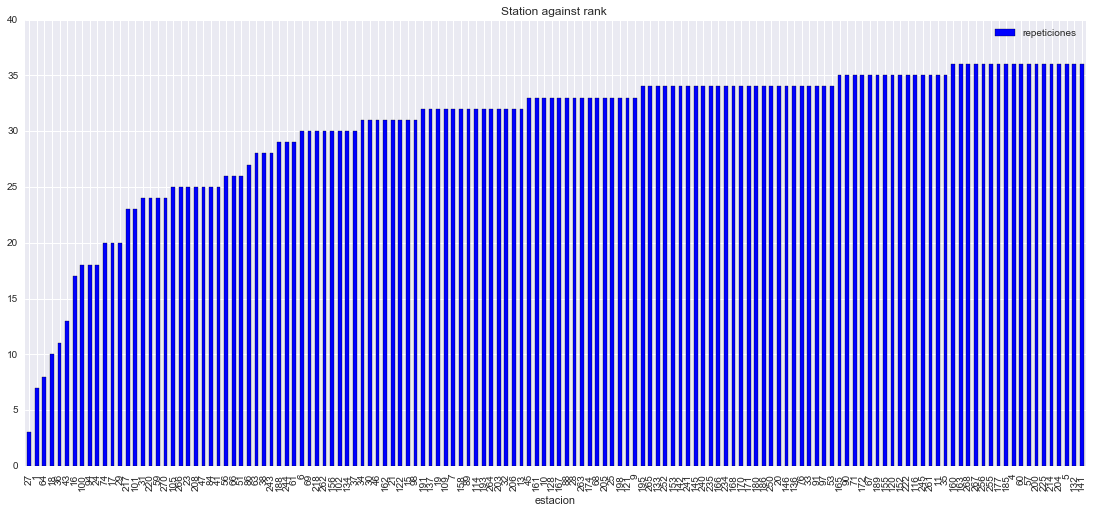

In [47]:
plot_rank_rep(friday)

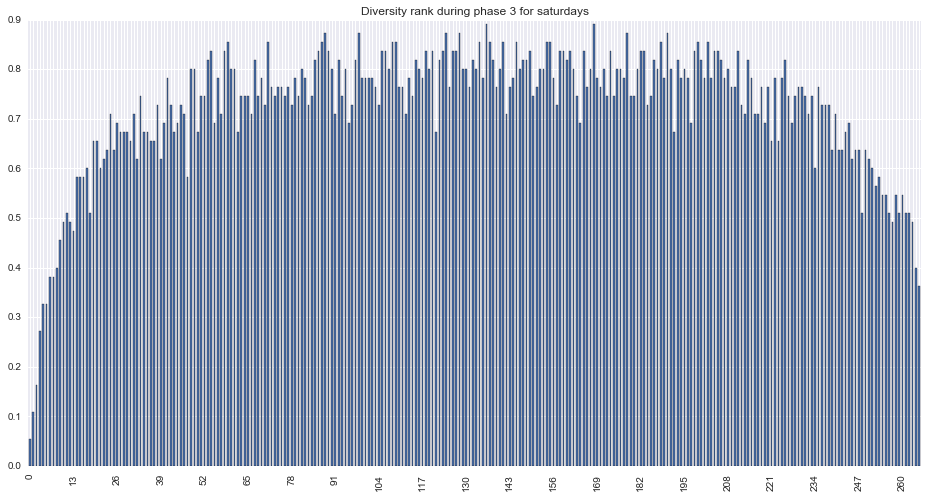

In [48]:
plot_dr(satuday,'Diversity rank during phase 3 for saturdays')

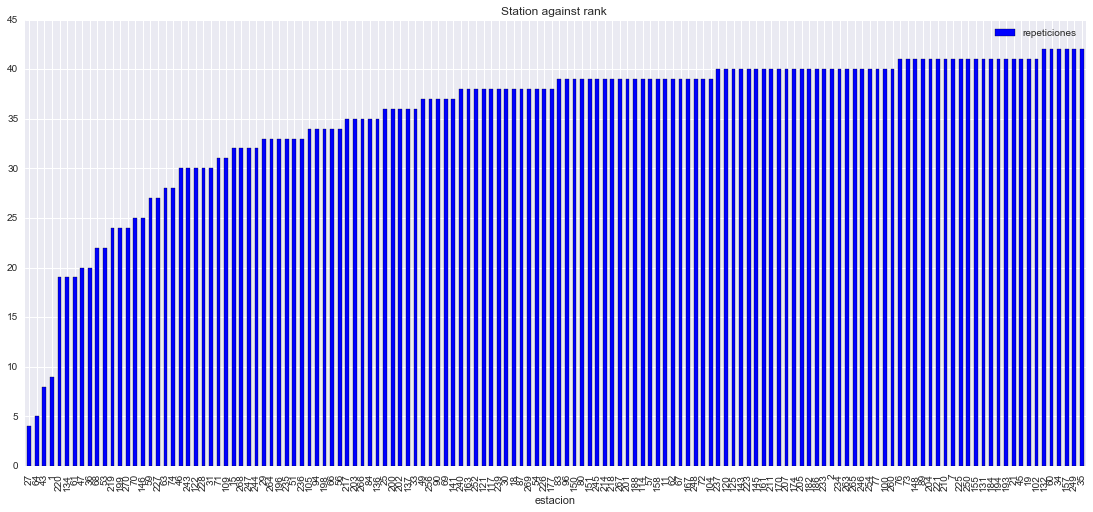

In [49]:
plot_rank_rep(satuday)

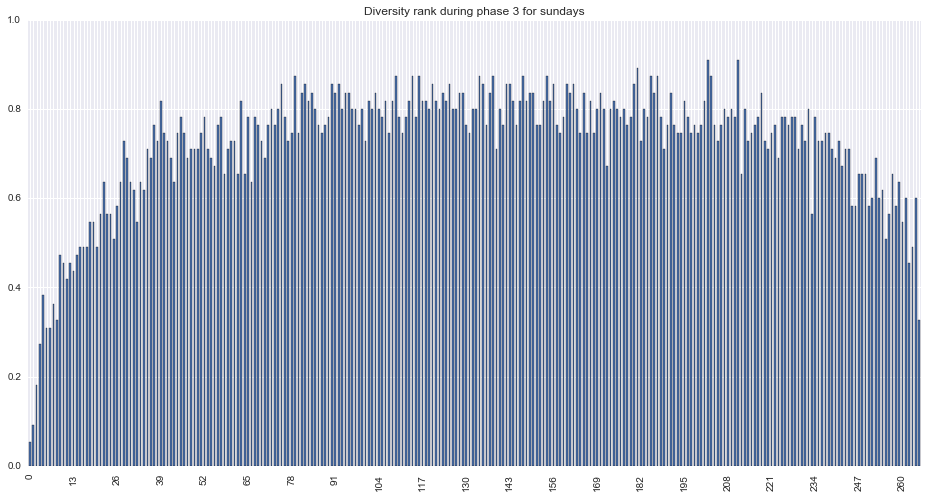

In [50]:
plot_dr(sunday,'Diversity rank during phase 3 for sundays')

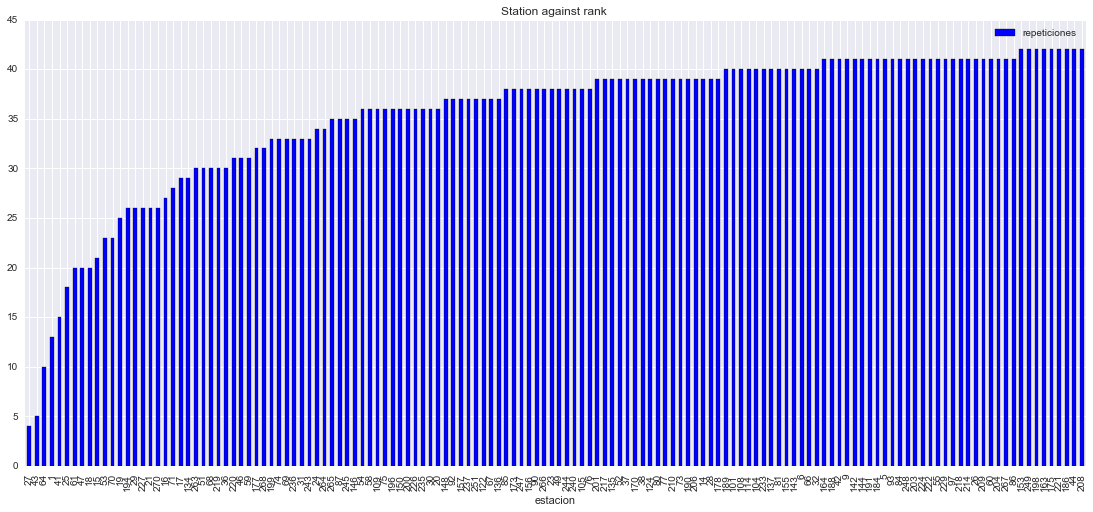

In [51]:
plot_rank_rep(sunday)

Con los experimentos anteriores cabe destacar las observaciones obtenidas:

- La diversidad de rango puede ser apreciada con la técnica de jerarquización utilizada en este notebook. Los puntos con menor variabilidad en el sistema son aquellos elementos que tuvieron los menores asi como los menores conteos a lo largo del periodo de funcionamiento en el sistema.

- No puede apreciarse una diferencia marcada si se realiza el análisis utilizando todos los días de la semana por igual o agrupándolos. La la tendencia y forma en la distribución se siguen conservando.

- Las estaciones con menor variabilidad están presentes en el análisis de diversidad de rango hecho para diferentes periodos.

# Conclusiones

De momento se ha logrado apreciar que la propiedad de diversidad de rango está presente en el sistema de Ecobici. En los siguiente notenook se hará un análisis de la variabilidad en las estaciones utilizando la variabilidad de la estación en cada rango y utilizando técnicas de clustering de boosting, en especial se usará consensus clustering para obtener dichos clustes.

In [52]:
from IPython.display import HTML
#To hide code from the nbviewer render
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')